# **DLAI PROJECT - 2019**
---
##**Elisabet Bayó, Guillem Bonafonte, Witold Drozdzowski, Jady Ramanandray**






#**Preparations of the environment**#

We import all the necessary libraries to use and train the neural networks and to visualize the data.
Just comment the `drive.mount('/content/gdrive')` line if you don't plan to save/load models from your google drive.


In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import copy
from torch.autograd import Variable


import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from numpy import array

from prettytable import PrettyTable
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


We define hyperparameters to use in the models as well as saving them. We also define to work on GPU when possible

In [0]:
hparams = {
    'batch_size':100,
    'num_epochs':5,
    'learning_rate':1e-3,
    'log_interval':100,
    'train_percentage':0.95,
    'autoencoder_criterion':nn.MSELoss(),
    'model_path':F"/content/gdrive/My Drive/Colab Notebooks/",
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

#**EXERCISE 1 : Convolutional Autoencoder**

##1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.




In [6]:
transform = transforms.ToTensor()

initial_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_size = int(hparams['train_percentage'] * len(initial_data))
validation_size = len(initial_data) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(initial_data, [train_size, validation_size])
test_dataset = test_data

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=hparams['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=hparams['batch_size'], shuffle=True)


0it [00:00, ?it/s]

9920512it [00:02, 3653009.35it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56858.53it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:04, 334412.72it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21294.12it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## 2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).


### a) Number of parameters per model
We define a function to count the number of parameters of a model

In [0]:
def model_params(model):
    number_of_paremeters=0
    for parameter in list(model.parameters()):
        neural_network=1
        for size_index in list(parameter.size()):
            neural_network = neural_network*size_index
        number_of_paremeters += neural_network
    return number_of_paremeters

### b) encoder

We define a convolutional encoder with two **(convolutional - max pooling - ReLU activation function)** layers, a** flattening layer **and a **fully connected layer**. This encoder takes the `bottleneck_size` as a parameter.

In [0]:
class Encoder(nn.Module):
  def __init__(self, bottleneck_size):
    super(Encoder, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 20, 3, padding=1)  
    self.conv2 = nn.Conv2d(20, 10, 3, padding=1)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(7*7*10,bottleneck_size) 
    self.relu = nn.ReLU()    
    self.pool = nn.MaxPool2d(2, 2)
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x) 
    
    x = self.flatten(x)
    x = self.linear(x)
    x = self.relu(x)

    return x

### c) decoder
We define the decoder network according to the previously defined encoder.
We use : a **fully connected layer** from bottleneck to 10*7*7, a **ReLU activation function**, an unflattening function (**view function**), and two transposed convolutional layers. The **first transposed convolution layer is followed by a ReLU activation**, and the **last one by a Sigmoid activation**, in order to scale the outputs between 0 and 1. Again, we have the `bottleneck_size` as a parameter for its configuration.

In [0]:
class Decoder(nn.Module):
  def __init__(self, bottleneck_size):
    super(Decoder, self).__init__()
    self.linear = nn.Linear(bottleneck_size, 10*7*7)
    self.t_conv1 = nn.ConvTranspose2d(10, 20, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(20, 1, 2, stride=2)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    
  def forward(self,code):
    x = code
    x = self.linear(x)
    x = self.relu(x)
    
    x = x.view([x.shape[0],10,7,7])
    x = self.t_conv1(x)
    x = self.relu(x)
    
    x = self.t_conv2(x)
    x = self.sigmoid(x)
    return x

## 3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

### a) Epochs preparation and other auxiliary functions

#### i) Definition of a train epoch

In [0]:
def train_epoch(train_loader, EncoderModel, DecoderModel, optimizer, criterion, hparams, epoch):
  EncoderModel.train()
  DecoderModel.train()
  
  loss = 0.0
  losses = []

  for batch_idx, (data) in enumerate(train_loader, 1):
      data = data[0].to(hparams['device'])
      optimizer.zero_grad()

      outputs = DecoderModel(EncoderModel(data))
      
      loss = criterion(outputs, data)
      
      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
          

  return losses


#### ii) Definition of the MSE loss over an image and then over a batch of images


In [0]:
def MSE_Image(imageA, imageB):
	err = np.sum((imageA.data.numpy() - imageB.data.numpy()) ** 2)
	err /= float((imageA.shape[0] * imageA.shape[1]))
	return err

In [0]:
def MSE_Batch (original, reconstructed, batch_size):
  err = 0
  for i in range (0,batch_size):
    err += MSE_Image(original[i].detach(),reconstructed[i].detach())
    err /= float(batch_size)
  return err

#### iii) Definition of the validation epoch

We set the models to **evaluation mode**. The `criterion` is set as a parameter for the validation step. We also have the option to calculate the average `Image_MSE`.

In [0]:
def eval_epoch(eval_loader,  EncoderModel, DecoderModel, criterion, hparams, printing=True, Image_MSE=False):
  EncoderModel.eval()
  DecoderModel.eval()
  
  eval_loss = 0
  avg_img = 0
  
  with torch.no_grad():
      for data in eval_loader:
          data = data[0].to(hparams['device']) 

          firstOutput = EncoderModel(data)
          outputs = DecoderModel(firstOutput)
          eval_loss += criterion(outputs, data).item()
          
          if Image_MSE:
            avg_img += MSE_Batch(data,outputs,hparams['batch_size'])

      eval_loss /=len(eval_loader)
      avg_img /= len (eval_loader)

  if printing:
    print('Eval set: Average loss: {:.15f}'.format(eval_loss))
  
  if Image_MSE:
    return eval_loss, avg_img
  else:  
    return eval_loss

#### iv) We define a function to train a whole autoencoder

We use **Adam** as optimizer because it is effective and has benefits from AdaGrad (deals with problems including sparse gradients) and RMSProp (deals with online and noisy problems). <br>
We use **MSELoss** as criterion because the reconstructed image from the autoencoder is a real-valued of the input images.

In [0]:
def train_autoencoder(myEncoder, myDecoder,criterion):
  train_losses = []
  eval_losses = []
  test_losses = []

  myEncoder.to(hparams['device'])
  myDecoder.to(hparams['device'])

  optimizer = optim.Adam(list(myEncoder.parameters()) + list(myDecoder.parameters()), lr=hparams['learning_rate'])

  for epoch in range(1, hparams['num_epochs'] + 1):
    tr_loss = train_epoch(train_loader, myEncoder, myDecoder, optimizer, criterion, hparams, epoch)
    te_loss = eval_epoch(validation_loader, myEncoder, myDecoder, criterion, hparams)
    train_losses.append(tr_loss)
    eval_losses.append(te_loss)
    

  return myEncoder, myDecoder, train_losses, eval_losses

#### v) Save models

We define a function to save the models in the Drive so we don't have to train them in every execution of the notebook

In [0]:
def save_models():

  for bottleneck_size in bottlenecks:
    model_save_name = 'myEncoder' + str(bottleneck_size) + '.pt'
    path = hparams["model_path"] + model_save_name
    torch.save(myEncoders[bottleneck_size].state_dict(), path)
    
    model_save_name = 'myDecoder' + str(bottleneck_size) + '.pt'
    path = hparams["model_path"] + model_save_name
    torch.save(myDecoders[bottleneck_size].state_dict(), path)


#### vi) Load models

We define a function that loads one model from Drive, and another one that loads a series of models by a list of bottleneck sizes. Both of them generate again the variables `myEncoders` and `myDecoders` in which we save all the trained models.

In [0]:
def load_model(modelname, modelClass):
  
  path = hparams['model_path'] + modelname +'.pt'
  modelClass.load_state_dict(torch.load(path))

In [0]:
def load_all_models(bottlenecks):

  myEncoders = {}
  myDecoders = {}

 
  for each_bottleneck_size in bottlenecks:
    myLoadedEncoder = Encoder(each_bottleneck_size)
    myLoadedDecoder = Decoder(each_bottleneck_size)

    model_load_name = 'myEncoder' + str(each_bottleneck_size)
    load_model(model_load_name, myLoadedEncoder)
    myEncoders[each_bottleneck_size] = (myLoadedEncoder)
    
    model_load_name = 'myDecoder' + str(each_bottleneck_size)
    load_model(model_load_name, myLoadedDecoder)
    myDecoders[each_bottleneck_size] = (myLoadedDecoder)

  
  return myEncoders,myDecoders

### b) Training

We train the autoendoer with different sizes of the bottleneck (`bottlenecks`)

#### i) Train autoencoders

In [0]:
bottlenecks = [5,20,50,70]

In [0]:
train_me = False

if train_me :

  myEncoders = {}
  myDecoders = {}
  myTrain_losses = []
  myEval_losses = []

  for bottleneck_size in bottlenecks:
    print("\n***************** BOTTLENECK SIZE:",bottleneck_size," ************************")
    myEncoder = Encoder(bottleneck_size)  
    myDecoder = Decoder(bottleneck_size)

    myTrainResults = train_autoencoder(myEncoder, myDecoder,hparams['autoencoder_criterion'])
    myEncoders[bottleneck_size] = (myTrainResults[0])
    myDecoders[bottleneck_size] = (myTrainResults[1])
    myTrain_losses.append(myTrainResults[2])
    myEval_losses.append(myTrainResults[3])


#### ii) Save models
Only to be executed if we want to save them for a future execution of the notebook


In [0]:
save_models()

### c) Plot loss curves

In [0]:
plt.figure(figsize=(20, 16))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

general_marker_size = 15
general_linewidth = 1
number_of_losspoints_per_epoch = len(train_dataset)/hparams['batch_size']
x_labels = [number_of_losspoints_per_epoch * i for i in range(1,hparams['num_epochs']+1)]
colors = ['blue','orange','red','yellow']

number_of_models = range(0,len(myTrain_losses),1)

for model_number,bt in zip(number_of_models,bottlenecks):
  plt.plot(list(itertools.chain(*myTrain_losses[model_number])), label='Train loss, bottleneck = '+ str(bt), marker='', linewidth=general_linewidth, color=colors[model_number])
  plt.plot(x_labels,myEval_losses[model_number],label='Evaluation loss, bottleneck = ' + str(bt), marker='o', markersize=general_marker_size, linewidth=0, color=colors[model_number])


plt.xticks(x_labels, range(1,hparams['num_epochs']+1))

plt.legend();



## 4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including number of parameters of each model.

#### Load models
Only to be executed if we are using saved models and we haven't trained them in this session. Make sure we have executed the code cell where we define `bottlenecks`, in section 3b.i

In [0]:
myEncoders,myDecoders = load_all_models(bottlenecks)

In [22]:
test_losses_of_a_model = []
test_losses = []
eval_losses_of_a_model = []
eval_losses = []
img_MSE_val = []
img_MSE_test = []

myTable = PrettyTable(['Model #','Size of bottleneck', 'Average validation MSE','Average test MSE', 'Number of parameters'])

index=1

for bottleneck_size in bottlenecks:
   
  eval_loss,img_avg = eval_epoch(validation_loader,  myEncoders[bottleneck_size], myDecoders[bottleneck_size], hparams['autoencoder_criterion'], hparams, False, True)
  eval_losses_of_a_model.append(eval_loss)
  img_MSE_val.append(img_avg)
  
  test_loss, img_avg = eval_epoch(test_loader,  myEncoders[bottleneck_size], myDecoders[bottleneck_size], hparams['autoencoder_criterion'], hparams, False, True)
  test_losses_of_a_model.append(test_loss)
  img_MSE_test.append(img_avg)

  
  eval_losses.append(eval_losses_of_a_model)
  test_losses.append(test_losses_of_a_model)

  
  myTable.add_row([str(index),bottleneck_size,np.mean(img_MSE_val),np.mean(img_MSE_test), model_params(myEncoders[bottleneck_size]) + model_params(myDecoders[bottleneck_size])])
  index +=1

print(myTable)

+---------+--------------------+------------------------+----------------------+----------------------+
| Model # | Size of bottleneck | Average validation MSE |   Average test MSE   | Number of parameters |
+---------+--------------------+------------------------+----------------------+----------------------+
|    1    |         5          |  0.015558084903593124  | 0.015867808094196977 |         8306         |
|    2    |         20         |  0.011683533429937167  | 0.011775754439942955 |        23021         |
|    3    |         50         |  0.010045952569865497  | 0.00999381400359565  |        52451         |
|    4    |         70         |  0.009192486885869478  | 0.00906986981668036  |        72071         |
+---------+--------------------+------------------------+----------------------+----------------------+


## 5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.



We choose the model with **lowest Average MSE error** and we save the bottleneck_size as a new hyperparameter.

In [0]:
hparams['bottleneck_size'] = 70 

In [0]:
def renderImages(images, output):
  images = images.numpy()

  output = output.view(hparams['batch_size'], 1, 28, 28)
  output = output.detach().numpy()

  fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,4))

  for images, row in zip([images, output], axes):
      for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.label_outer()

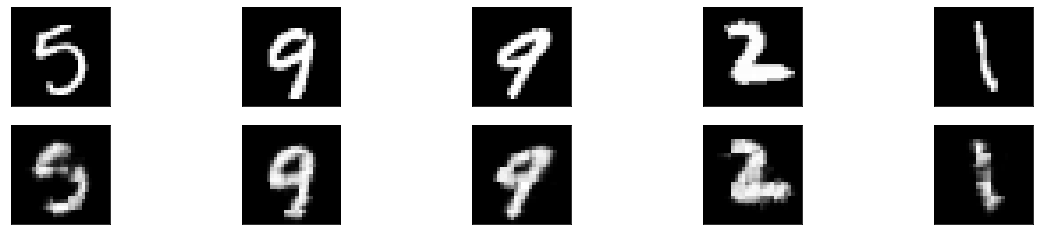

In [25]:
SelectedEncoder = myEncoders[hparams['bottleneck_size']]
SelectedDecoder = myDecoders[hparams['bottleneck_size']]

dataiter = iter(test_loader)
images_, labels_ = dataiter.next()

images, labels = images_, labels_

output = SelectedDecoder(SelectedEncoder(images))

renderImages(images,output)


## 6. Generate 5 new images by injecting random values as input to the decoder. Show them.

In [0]:
a = torch.randn(5,hparams['bottleneck_size'])
a.to(hparams['device'])

output = SelectedDecoder(a)
output = output.detach().numpy()

fig2, axes2 = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for i in range(5):
  im = output[i]
  axes2[i].imshow(np.squeeze(im), cmap='gray')
  axes2[i].axis('off')
plt.show()

# **EXERCISE 2 : Transfer Learning**

We need new hyper-parameters for this exercise.

The `batch_size_classifier` parameter has **to be smaller** than `number_of_images` so that we have **more than one batch per epoch**. <br>
The `num_of_epochs_classifier` parameter can be a **great number**, because we have **only 100 images** to train with. <br>
The digits are from 0 to 9: `num_classes` is then set to 10. <br>
For `classifier_criterion`, we have chosen the cross-entropy loss **nll_loss**, because it minimizes the distance between two probability distributions: predicted and actual labels.



In [0]:
hparams['number_of_images']=100
hparams['batch_size_classifier']=10
hparams['num_epochs_classifier']=100
hparams['num_classes']=10
hparams['classifier_criterion']=F.nll_loss
hparams['bottleneck_size']=70

## 1. Select a subset of 100 images and their associated labels from the MNIST training data.

In [0]:
sampling = random.choices(initial_data, k=hparams['number_of_images'])
classifier_train_loader = torch.utils.data.DataLoader(sampling, batch_size=hparams['batch_size_classifier'], shuffle=True)

iter_ = iter(classifier_train_loader)
bimg, blabel = next(iter_)
bimg_final = np.squeeze(bimg)

## 2. Select one of the previously trained autoencoders.

We load the encoder with the selected bottlenecck size trained from exercise 1. We will copy it as a base for the pre-training and later on, as a base for fine-tuning.

In [0]:
myTrainedEncoder = Encoder(hparams['bottleneck_size'])
load_model("myEncoder"+str(hparams['bottleneck_size']),myTrainedEncoder)

## 3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

### a) Define the Classification Model

In [0]:
class ClassificationModel(nn.Module):
  
  def __init__(self, theTrainedEncoder):
    super(ClassificationModel, self).__init__()
    self.trainedEncoder = theTrainedEncoder
    self.classifier = nn.Sequential(
        nn.Linear(hparams['bottleneck_size'], 50),
        nn.ReLU(),
        nn.Dropout(0.5),
        
        nn.Linear(50, hparams['num_classes']),
        nn.ReLU(),        
        nn.LogSoftmax()
        
        )

  def forward(self,x):
    x = self.trainedEncoder(x)
    x = self.classifier(x)

    return x

### b) Define the fuctions needed for training and validation

We define new functions: training and validating each epoch, and the general training function.

In [0]:
def train_epoch_classifier(train_loader, myClassificationModel, optimizer, criterion, hparams, epoch):
  
  myClassificationModel.train()
  
  loss = 0.0
  losses = []


  for data in train_loader:
    image = data[0].to(hparams['device'])
    label = data[1]
    optimizer.zero_grad()

    firstOutput = myClassificationModel(image)
    loss = criterion(firstOutput, label)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
  if epoch % 10 == 0:
    print('Train Epoch: {} \tAverage training loss: {:.6f}'.format(epoch, np.mean(losses)))
            
  return losses

In [0]:
def correct_predictions(output_batch, label_batch):
  pred = output_batch.argmax(dim=1, keepdim=True)
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def eval_epoch_classifier(eval_loader,  myClassificationModel, criterion, hparams, printing=True):
  myClassificationModel.eval()
  
  eval_loss = 0
  accuracy = 0
  
  with torch.no_grad():
      for data in eval_loader:
          image = data[0].to(hparams['device'])
          label = data[1].to(hparams['device'])
          firstOutput = myClassificationModel(image)
          eval_loss += criterion(firstOutput, label).item()
          accuracy += correct_predictions(firstOutput, label)

      eval_loss /=len(eval_loader)
      accuracy = 100. * accuracy /len(eval_loader.dataset)

  if printing:
    print('Eval set: Average loss: {:.15f}'.format(eval_loss))
    print('Acc set: A: {:.15f}'.format(accuracy))

  return eval_loss, accuracy


In [0]:
def train_classifier(train_loader, myClassificationModel, criterion, optimizer):
  
  train_losses = []

  myClassificationModel.to(hparams['device'])
  
  for epoch in range(1, hparams['num_epochs_classifier'] + 1):
    tr_loss = train_epoch_classifier(train_loader, myClassificationModel, optimizer, criterion, hparams, epoch)
    train_losses.append(tr_loss)

  return myClassificationModel, train_losses

## 4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

In [56]:
myTrainedEncoder_pre = copy.copy(myTrainedEncoder)

myClassificationModel_pre = ClassificationModel(myTrainedEncoder_pre)

classifier_optimizer_pre=optim.RMSprop(myClassificationModel_pre.parameters(), hparams['learning_rate'])

myTrainResults_pre = train_classifier(classifier_train_loader, myClassificationModel_pre, hparams['classifier_criterion'], classifier_optimizer_pre)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 10 	Average training loss: 1.209450
Train Epoch: 20 	Average training loss: 0.620761
Train Epoch: 30 	Average training loss: 0.593645
Train Epoch: 40 	Average training loss: 0.471965
Train Epoch: 50 	Average training loss: 0.368066
Train Epoch: 60 	Average training loss: 0.365645
Train Epoch: 70 	Average training loss: 0.376482
Train Epoch: 80 	Average training loss: 0.353926
Train Epoch: 90 	Average training loss: 0.354605
Train Epoch: 100 	Average training loss: 0.351993


## 5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

In [57]:
myTrainedEncoder_fine = copy.copy(myTrainedEncoder)

myClassificationModel_fine = ClassificationModel(myTrainedEncoder_fine)

classifier_optimizer_fine=optim.RMSprop([
                {'params': myClassificationModel_fine.trainedEncoder.parameters(), 'lr': 1e-9},
                {'params': myClassificationModel_fine.classifier.parameters()}
            ], lr=hparams['learning_rate'])

myTrainResults_fine = train_classifier(classifier_train_loader, myClassificationModel_fine, hparams['classifier_criterion'], classifier_optimizer_fine)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 10 	Average training loss: 0.941793
Train Epoch: 20 	Average training loss: 0.889251
Train Epoch: 30 	Average training loss: 0.564042
Train Epoch: 40 	Average training loss: 0.586865
Train Epoch: 50 	Average training loss: 0.509139
Train Epoch: 60 	Average training loss: 0.478508
Train Epoch: 70 	Average training loss: 0.450762
Train Epoch: 80 	Average training loss: 0.427694
Train Epoch: 90 	Average training loss: 0.442815
Train Epoch: 100 	Average training loss: 0.353524


## 6. From scratch: train the model on the 100 samples without reusing the encoder weights at all.

In [58]:
myEncoder_scratch = Encoder(hparams['bottleneck_size'])

myClassificationModel_scratch = ClassificationModel(myEncoder_scratch)

classifier_optimizer_scratch=optim.RMSprop(myClassificationModel_scratch.parameters(), hparams['learning_rate'])

myTrainResults_scratch = train_classifier(classifier_train_loader, myClassificationModel_scratch, hparams['classifier_criterion'], classifier_optimizer_scratch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 10 	Average training loss: 1.923797
Train Epoch: 20 	Average training loss: 1.159494
Train Epoch: 30 	Average training loss: 0.808275
Train Epoch: 40 	Average training loss: 0.673155
Train Epoch: 50 	Average training loss: 0.667959
Train Epoch: 60 	Average training loss: 0.603095
Train Epoch: 70 	Average training loss: 0.623187
Train Epoch: 80 	Average training loss: 0.603898
Train Epoch: 90 	Average training loss: 0.597093
Train Epoch: 100 	Average training loss: 0.589967


## 7. Show the accuracy of the four models on the MNIST test set in a table.

In [59]:
classifier_loss_acc_pre = eval_epoch_classifier(test_loader,myClassificationModel_pre,hparams['classifier_criterion'],hparams,False)
classifier_loss_acc_fine= eval_epoch_classifier(test_loader,myClassificationModel_fine,hparams['classifier_criterion'],hparams,False)
classifier_loss_acc_scratch= eval_epoch_classifier(test_loader,myClassificationModel_scratch,hparams['classifier_criterion'],hparams,False)

accuracy_table = PrettyTable(['Classifier type','Accuracy'])

accuracy_table.add_row(["Pretrained",classifier_loss_acc_pre[1]])
accuracy_table.add_row(["Finetuned",classifier_loss_acc_fine[1]])
accuracy_table.add_row(["From scratch",classifier_loss_acc_scratch[1]])

print(accuracy_table)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


+-----------------+----------+
| Classifier type | Accuracy |
+-----------------+----------+
|    Pretrained   |  68.53   |
|    Finetuned    |  72.53   |
|   From scratch  |  66.68   |
+-----------------+----------+


# **Optional Exercise A: Variational Autoencoder**

## 1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.

We define a convolutional variational encoder and decoder with the same architecture as before.

In [0]:
class VariationalEncoder(nn.Module):
  def __init__(self, bottleneck_size):
    super(VariationalEncoder, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 20, 3, padding=1)  
    self.conv2 = nn.Conv2d(20, 10, 3, padding=1)
    self.flatten = nn.Flatten()
    self.linearMu = nn.Linear(7*7*10,bottleneck_size)
    self.linearLV = nn.Linear(7*7*10,bottleneck_size)
    self.relu = nn.ReLU()    
    self.pool = nn.MaxPool2d(2, 2)
    

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.flatten(x)
    return self.linearMu(x), self.linearLV(x)

In [0]:
class VariationalDecoder(nn.Module):
  def __init__(self, bottleneck_size):
    super(VariationalDecoder, self).__init__()
    self.linear = nn.Linear(bottleneck_size, 10*7*7)
    self.t_conv1 = nn.ConvTranspose2d(10, 20, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(20, 1, 2, stride=2)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    
  def forward(self,code):
    x = code
    x = self.linear(x)
    x = self.relu(x)
    
    x = x.view([x.shape[0],10,7,7])

    x = self.t_conv1(x)
    x = self.relu(x)
    
    x = self.t_conv2(x)
    x = self.sigmoid(x)
    return x

In [0]:
def reparametrize (mu, logvar):
  std = logvar.mul(0.5).exp_()
  eps = Variable(std.data.new(std.size()).normal_())
  return eps.mul(std).add_(mu)

In [0]:
reconstruction_function = nn.MSELoss(size_average=False)

In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x) 
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

In [0]:
def train_epoch_variational(train_loader, EncoderModel, DecoderModel, optimizer, hparams, epoch):
  
  EncoderModel.train()
  DecoderModel.train()
  
  loss = 0.0
  losses = []

  for batch_idx, (data) in enumerate(train_loader, 1):
      data = data[0].to(hparams['device'])
      optimizer.zero_grad()

      mu, logvar = EncoderModel(data)
      fixedresult = reparametrize(mu, logvar)
      outputs = DecoderModel(fixedresult)

      loss = loss_function(outputs, data, mu, logvar)

      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
          

  return losses 

In [0]:
def train_variational_autoencoder(myEncoder, myDecoder):
  train_losses = []
  myEncoder.to(hparams['device'])
  myDecoder.to(hparams['device'])

  optimizer = optim.Adam(list(myEncoder.parameters()) + list(myDecoder.parameters()), lr=hparams['learning_rate'])
  
  for epoch in range(1, hparams['num_epochs'] + 1):
    tr_loss = train_epoch_variational(train_loader, myEncoder, myDecoder, optimizer, hparams, epoch)
    train_losses.append(tr_loss)
    

  return myEncoder, myDecoder, train_losses

## 2. Train the model optimizing the Evidence Lower Bound (ELBO).

In [0]:
  bottleneck_size_VA = 50
 
  myVEncoder = VariationalEncoder(bottleneck_size_VA) 
  myVDecoder = VariationalDecoder(bottleneck_size_VA)

  myTrainResults = train_variational_autoencoder(myVEncoder, myVDecoder)

In [0]:
dataiter = iter(test_loader)
images_, labels_ = dataiter.next()

images, labels = images_, labels_

mu, logvar = myVEncoder(images)
output = myVDecoder(mu)

renderImages(images,output)

## 3. Generate samples with the decoder and show them.

In [0]:

random_5_numbers = torch.randn(5,bottleneck_size_VA)
random_5_numbers.to(hparams['device'])

output = myVDecoder(random_5_numbers)
output = output.detach().numpy()

fig2, axes2 = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for i in range(5):
  im = output[i]
  axes2[i].imshow(np.squeeze(im), cmap='gray')
  axes2[i].axis('off')
plt.show()